In [1]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter

In [2]:
#Make a big data set with 
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [3]:
orders=orders.loc[orders['eval_set']=='prior']

In [4]:
#We will work with 5000 users, last order will be in test set
users=range(1,5001)
orders_set=orders[orders["user_id"].isin(users)]
idx_test = orders_set.groupby(['user_id'])['order_number'].transform(max) == orders_set['order_number']
orders_set_test=orders_set[idx_test]

In [53]:
orders_set_testlist=np.unique(orders_set_test.order_id)
orders_set_train = orders_set[-orders_set["order_id"].isin(orders_set_testlist)]
orders_set_trainlist=np.unique(orders_set_train.order_id)

In [54]:
train= order_products_prior[order_products_prior["order_id"].isin(orders_set_trainlist)]
test=order_products_prior[order_products_prior["order_id"].isin(orders_set_testlist)]
train = pd.merge(train, orders_set_train, on='order_id', how='left')
test=pd.merge(test, orders_set_test, on='order_id', how='left')

In [7]:
#we will work with jus some part of prior and we will divide it in train and test
#short_prior=order_products_prior[:500004]
#train=short_prior[:350010]
#test=short_prior[350010:]

In [8]:
print('Train set has %f orders',len(np.unique(train.order_id)))
print('Test set has %f orders',len(np.unique(test.order_id)))

Train set has %f orders 71832
Test set has %f orders 5000


In [9]:
print('Train set has %f users',len(np.unique(train.user_id)))
print('Test set has %f users',len(np.unique(test.user_id)))

Train set has %f users 5000
Test set has %f users 5000


In [10]:
train_orders = train.set_index('order_id')['product_id'].rename('item_id')
train_orders.head()

order_id
8     23423
74    46667
74    14129
74    11136
74    27247
Name: item_id, dtype: int64

In [11]:
test_orders = test.set_index('order_id')['product_id'].rename('item_id')
test_orders.head()

order_id
40     10070
40     42450
40     33198
40     34866
504    19894
Name: item_id, dtype: int64

In [12]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))

# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]   

In [13]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [14]:
rules = association_rules(train_orders, 0.01)  

Starting order_item:                 710227
Items with support >= 0.01:           10544
Remaining order_item:                664072
Remaining orders with 2+ items:       67473
Remaining order_item:                660034


/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Item pairs:                         2308248
Item pairs with support >= 0.01:      80043



In [15]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Cherry Caffeine Free Unsweetened Soft Drink Mix,Orange Unsweetened Soft Drink Mix,8,0.011857,10,0.014821,9,0.013339,0.800000,0.888889,59.976000
5,Dora and Friends Fruit Snacks,Sponge Bob Square Pants Fruit Snacks,7,0.010375,10,0.014821,8,0.011857,0.700000,0.875000,59.038875
1,Tropical Punch Unsweetened Soft Drink Mix,Orange Unsweetened Soft Drink Mix,8,0.011857,11,0.016303,9,0.013339,0.727273,0.888889,54.523636
17,Strawberry ZFruit,Kids Mixed Berry Twisted Fruit,7,0.010375,10,0.014821,9,0.013339,0.700000,0.777778,52.479000
2,Grape Unsweetened Soft Drink Mix,Orange Unsweetened Soft Drink Mix,7,0.010375,10,0.014821,9,0.013339,0.700000,0.777778,52.479000
18,Organic Bold Original Cacao Superfood Drink,Coconut Cacao Drink,8,0.011857,14,0.020749,8,0.011857,0.571429,1.000000,48.195000
3,Cherry Caffeine Free Unsweetened Soft Drink Mix,Grape Unsweetened Soft Drink Mix,7,0.010375,10,0.014821,10,0.014821,0.700000,0.700000,47.231100
1144,Chocolate Breakfast Bites,Asian Pear Crisps,7,0.010375,13,0.019267,8,0.011857,0.538462,0.875000,45.414519
4,Cherry Caffeine Free Unsweetened Soft Drink Mix,Tropical Punch Unsweetened Soft Drink Mix,7,0.010375,10,0.014821,11,0.016303,0.700000,0.636364,42.937364
19,Cacao Chocolate Mint,Coconut Cacao Drink,7,0.010375,14,0.020749,8,0.011857,0.500000,0.875000,42.170625


In [88]:
#Train set pairs
train_pairs_gen=get_item_pairs(train_orders)
train_pairs = freq(train_pairs_gen).to_frame("freqAB")
train_pairs = train_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
train_pairs['pair']=train_pairs.item_A.astype(str).str.cat(train_pairs.item_B.astype(str), sep='-')
train_pairs.head()

/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


,item_A,item_B,freqAB,pair
0,46667,14129,8,46667-14129
1,46667,11136,2,46667-11136
2,46667,27247,3,46667-27247
3,46667,17902,1,46667-17902
4,46667,45681,3,46667-45681


In [86]:
#Test set pairs
test_pairs_gen=get_item_pairs(test_orders)
test_pairs = freq(test_pairs_gen).to_frame("freqAB")
test_pairs = test_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
test_pairs['pair']=test_pairs.item_A.astype(str).str.cat(test_pairs.item_B.astype(str), sep='-')
test_pairs.head()

(2884586, 3)

In [19]:
#Rules set pairs
rules['pair']=rules.item_A.astype(str).str.cat(rules.item_B.astype(str), sep='-')
np.shape(rules)

(80043, 12)

In [100]:
test_pair_set=set(np.unique(test_pairs.pair))
train_pair_set=set(np.unique(train_pairs.pair))
rules_pair_set=set(np.unique(rules.pair))

#TP= Pairs that exist in a priori pred and test
tp=len(list(test_pair_set&rules_pair_set))

#TN= pairs that exists train set but not in test
tn=len(list(test_pair_set-train_pair_set))

#FN= Pairs that exists in test but not in a priori
fn=len(list(rules_pair_set-test_pair_set))

#FP= Pairs that exists in a priori but not in test
fp=len(list(test_pair_set-rules_pair_set))



In [105]:
accuracy=(tp+tn)/(tp+fp+fn+tn)
precision=tp/(tp+fp)
recall=tp/(tp+fn)
f1=2*(recall*precision)/(recall+precision)

In [106]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.3874024545012691
Precision: 0.09729812815958465
Recall: 0.4270454630636033
F1: 0.15848662934242097


In [160]:
conditions_train= [
    (train['order_hour_of_day'] >= 0) & (train['order_hour_of_day'] < 6),
    (train['order_hour_of_day'] >= 6) & (train['order_hour_of_day'] < 9),
    (train['order_hour_of_day'] >= 9) & (train['order_hour_of_day'] < 12),
    (train['order_hour_of_day'] >= 12) & (train['order_hour_of_day'] < 15),
    (train['order_hour_of_day'] >= 15) & (train['order_hour_of_day'] < 18),
    (train['order_hour_of_day'] >= 18) & (train['order_hour_of_day'] < 21),
    (train['order_hour_of_day'] >= 21) & (train['order_hour_of_day'] < 24)]

conditions_test= [
    (test['order_hour_of_day'] >= 0) & (test['order_hour_of_day'] < 6),
    (test['order_hour_of_day'] >= 6) & (test['order_hour_of_day'] < 9),
    (test['order_hour_of_day'] >= 9) & (test['order_hour_of_day'] < 12),
    (test['order_hour_of_day'] >= 12) & (test['order_hour_of_day'] < 15),
    (test['order_hour_of_day'] >= 15) & (test['order_hour_of_day'] < 18),
    (test['order_hour_of_day'] >= 18) & (test['order_hour_of_day'] < 21),
    (test['order_hour_of_day'] >= 21) & (test['order_hour_of_day'] < 24)]

conditions_orders_set= [
    (orders_set['order_hour_of_day'] >= 0) & (orders_set['order_hour_of_day'] < 6),
    (orders_set['order_hour_of_day'] >= 6) & (orders_set['order_hour_of_day'] < 9),
    (orders_set['order_hour_of_day'] >= 9) & (orders_set['order_hour_of_day'] < 12),
    (orders_set['order_hour_of_day'] >= 12) & (orders_set['order_hour_of_day'] < 15),
    (orders_set['order_hour_of_day'] >= 15) & (orders_set['order_hour_of_day'] < 18),
    (orders_set['order_hour_of_day'] >= 18) & (orders_set['order_hour_of_day'] < 21),
    (orders_set['order_hour_of_day'] >= 21) & (orders_set['order_hour_of_day'] < 24)]


choices = ['0.6', '6.9', '9.12', '12.15', '15.18', '18.21','21.23']
train['time_range'] = np.select(conditions_train, choices)
test['time_range'] = np.select(conditions_test, choices)
orders_set['time_range']=np.select(conditions_orders_set, choices)

/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [148]:
results=[]

for i in choices:
    print(i)
    train_i= train[train['time_range'] == i]
    test_i= test[test['time_range'] == i]
    
    train_orders_i = train_i.set_index('order_id')['product_id'].rename('item_id')
    test_orders_i = test_i.set_index('order_id')['product_id'].rename('item_id')
    
    rules_i = association_rules(train_orders_i, 0.01)  
    rules_final_i = merge_item_name(rules_i, item_name).sort_values('lift', ascending=False)
    display(rules_final_i)
    
    #Train set pairs
    train_pairs_gen_i=get_item_pairs(train_orders_i)
    train_pairs_i = freq(train_pairs_gen_i).to_frame("freqAB")
    train_pairs_i = train_pairs_i.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    train_pairs_i['pair']=train_pairs_i.item_A.astype(str).str.cat(train_pairs_i.item_B.astype(str), sep='-')
    
    #Test set pairs
    test_pairs_gen_i=get_item_pairs(test_orders_i)
    test_pairs_i = freq(test_pairs_gen_i).to_frame("freqAB")
    test_pairs_i = test_pairs_i.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    test_pairs_i['pair']=test_pairs_i.item_A.astype(str).str.cat(test_pairs_i.item_B.astype(str), sep='-')
    
    #Rules set pairs
    rules_i['pair']=rules_i.item_A.astype(str).str.cat(rules_i.item_B.astype(str), sep='-')
    np.shape(rules)
    
    test_pair_set_i=set(np.unique(test_pairs_i.pair))
    train_pair_set_i=set(np.unique(train_pairs_i.pair))
    rules_pair_set_i=set(np.unique(rules_i.pair))

    #TP= Pairs that exist in a priori pred and test
    tp_i=len(list(test_pair_set_i&rules_pair_set_i))

    #TN= pairs that exists train set but not in test
    tn_i=len(list(test_pair_set_i-train_pair_set_i))

    #FN= Pairs that exists in test but not in a priori
    fn_i=len(list(rules_pair_set_i-test_pair_set_i))

    #FP= Pairs that exists in a priori but not in test
    fp_i=len(list(test_pair_set_i-rules_pair_set_i))
    
    
    accuracy_i=(tp_i+tn_i)/(tp_i+fp_i+fn_i+tn_i)
    precision_i=tp_i/(tp_i+fp_i)
    recall_i=tp_i/(tp_i+fn_i)
    f1_i=2*(recall_i*precision_i)/(recall_i+precision_i)
    results.append([i,precision_i, accuracy_i, recall_i,f1_i])

0.6
Starting order_item:                  12222
Items with support >= 0.01:            4877
Remaining order_item:                 12222
Remaining orders with 2+ items:        1172
Remaining order_item:                 12158


/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Item pairs:                           89570
Item pairs with support >= 0.01:      89570



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,VEGET TOMATO BASIL,Smoked Apple Sage Sausages,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68619,"Flour, All Purpose, Enriched, Bleached",Light Mayonnaise,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68642,"Flour, All Purpose, Enriched, Bleached",Turkey Gravy Mix,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68641,Sweet Cream Salted Butter,Turkey Gravy Mix,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68640,Carnation Sweetened Condensed Milk,Turkey Gravy Mix,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68639,Garden Herb Triscuit Crackers,Turkey Gravy Mix,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68638,Fridge and Freezer Baking Soda Pack,Turkey Gravy Mix,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68637,Half And Half Cream,Turkey Gravy Mix,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68623,Chicken Stock,Light Mayonnaise,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000
68622,Potatoes Sweet,Light Mayonnaise,1,0.085324,1,0.085324,1,0.085324,1.000000,1.000000,11.720000


6.9
Starting order_item:                  65504
Items with support >= 0.01:           11349
Remaining order_item:                 65504
Remaining orders with 2+ items:        6110
Remaining order_item:                 65139
Item pairs:                          395477
Item pairs with support >= 0.01:     395477



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Extra Stout,Organic Beef Stock,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279838,Hashbrown,30 Dose Laxative Powder,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279851,Cheddar Cheese Finely Shredded,Cinnamon Bun Sandwich Cookies,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279852,Naturals Applewood Smoked Ham Lunchmeat,Cinnamon Bun Sandwich Cookies,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279853,Fudge Brownie Mix,Cinnamon Bun Sandwich Cookies,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279854,Tilapia Fillets,Cinnamon Bun Sandwich Cookies,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279855,Kids Cavity Protection Sparkle Fun Flavor Toot...,Cinnamon Bun Sandwich Cookies,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279856,30 Dose Laxative Powder,Cinnamon Bun Sandwich Cookies,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279857,Hashbrown,Cinnamon Bun Sandwich Cookies,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000
279903,Cheddar Cheese Finely Shredded,Milk Chocolate Chips Baking Pieces,1,0.016367,1,0.016367,1,0.016367,1.000000,1.000000,61.100000


9.12
Starting order_item:                 177659
Items with support >= 0.01:           11747
Remaining order_item:                171392
Remaining orders with 2+ items:       16694
Remaining order_item:                170367
Item pairs:                          866356
Item pairs with support >= 0.01:     163911



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Snack Size Divine Triple Chocolate Ice Cream Bars,72% Cacao Twilight Delight Intense Dark Bar,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
596,Squared Plastic Bowl 20 Ounce,Salmon Feast in Seared Salmon Flavor Gravy Cat...,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
5354,Acti-Fresh Body Shape Pantiliners Long Unscent...,Yogurt Raisins,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
5355,Cherry Pomegranate Drink Mix,Fruity Dyno Bites Cereal,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
7993,Ultra Thin Armor Spermicidal Lubricant Condoms,Grass Fed Ground Lamb,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
7992,Pure Vanilla Joy Candle,Grass Fed Ground Lamb,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
7990,Select Tender Chicken with Vegetables & Brown ...,Berry Sparkling Water Beverage,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
11176,100% Whole Wheat Pizza Crust,Original Pizza Sauce,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
7855,"Pear, Kiwi, Peas & Spinach Organic Baby Food","Baby Food, Organic, Peach, Banana & Raspberry ...",2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000
11185,Coconut Cream Mini Pies,Single Serve Chocolate Satin Mini Pies,2,0.011980,2,0.011980,2,0.011980,1.000000,1.000000,83.470000


12.15
Starting order_item:                 172129
Items with support >= 0.01:           11714
Remaining order_item:                165605
Remaining orders with 2+ items:       16531
Remaining order_item:                164694
Item pairs:                          825786
Item pairs with support >= 0.01:     146507



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Sesame Water Crackers,Petite Snack Crunchers Kosher Dill Pickles,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
5923,Mini Double Chocolate Ice Cream Bars,White Vanilla Bean Ice Cream Dipped in White C...,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
3913,Yakisoba Instant Noodle Soup,Organic Asian Sesame Dressing,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
3957,Moisturizing Shampoo Strawberries & Cream,Moisture Milks Strawberries & Cream Moisturizi...,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
68,"Yogurt, Sheep Milk, Strawberry",Blueberry Sheep Milk Yogurt,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
3970,Fat Free Sharp Cheddar Pasteurized Process Che...,Fat Free Mozzarella,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
5319,Organic Einkorn Crispy Cocoa Cookies,Gluten Free Chocolate Creme Filled Chocolate C...,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
5390,No Caffeine Lemon Lime Soda,Chicken & Cheese Taquitos,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
5535,Graduates Lil' Entrees Pasta Stars In Meat Sau...,Graduates Lil EntreesnMacaroni and Cheese with...,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000
5536,Graduates Lil' Entrees Pasta Stars In Meat Sau...,Graduates Grabbers Fruit & Yogurt Strawberry B...,2,0.012098,2,0.012098,2,0.012098,1.000000,1.000000,82.655000


15.18
Starting order_item:                 158786
Items with support >= 0.01:           11375
Remaining order_item:                152322
Remaining orders with 2+ items:       15491
Remaining order_item:                151457
Item pairs:                          758869
Item pairs with support >= 0.01:     127990



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Chicken & Salmon Cat Food,Turkey & Brown Rice Wet Cat Food,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
2416,Organic Microgreens Italian,Organic 70% Dark Chocolate Bar,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
35,Chocolate Fudge Ice Cream Bars,Ready to Eat Tuna Salad Original Deli Style,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
36,Marketplace Spicy Mexican Black Beans and Rice,Ready to Eat Tuna Salad Original Deli Style,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
561,European Bowl Brush & Caddy,Vegetarian Vegetable Extra Large Cubes Bouillon,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
562,Moisturizing Body Wash Juicy Pomegranate & Man...,Vegetarian Vegetable Extra Large Cubes Bouillon,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
2185,Cafe Domingo Coffee K-Cups,Tissue Plus Lotion,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
11744,French Vanilla Sugar Free Coffee Creamer,Protein Plus Rotini Pasta,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
2262,Classic Romaine,Cinnamon Apple Sauce,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000
2321,Unsweet Peach Sparkling Water,Unsweet Watermelon Sparkling Water,2,0.012911,2,0.012911,2,0.012911,1.000000,1.000000,77.455000


18.21
Starting order_item:                  85906
Items with support >= 0.01:           14079
Remaining order_item:                 85906
Remaining orders with 2+ items:        8563
Remaining order_item:                 85515
Item pairs:                          477676
Item pairs with support >= 0.01:     477676



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Crisp Clean Antibacterial Hand Soap With Moist...,Chewy Dipps Peanut Butter Granola Bar,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
354725,Mac and Cheese Shells & White Cheddar Cheese,Mini Powdered Donuts,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
259542,White Corn Tortilla Strips,Cinnamon Crunch Snackimals Cereal,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
259541,Organic American Pasteurized Process Cheese Pr...,Cinnamon Crunch Snackimals Cereal,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
259514,Whole Wheat Penne Rigate,Basil Leaves,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
354672,Liquid Upset Stomach Reliever/Anti-Diarrheal,Extra Strenght Antigas Chewable Cherry Crème,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
354673,Unsalted Sweet Butter Sticks,Extra Strenght Antigas Chewable Cherry Crème,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
259450,Organic Heirloom Tomatoes,Sprouted Sunflower Seeds,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
259370,Original Scent Dish Soap,Power Up Greens Spring Mix & Greens,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000
354727,Mac and Cheese Shells & White Cheddar Cheese,Cucumber and Green Tea Body Wash,1,0.011678,1,0.011678,1,0.011678,1.000000,1.000000,85.630000


21.23
Starting order_item:                  38021
Items with support >= 0.01:            9019
Remaining order_item:                 38021
Remaining orders with 2+ items:        3369
Remaining order_item:                 37847
Item pairs:                          252131
Item pairs with support >= 0.01:     252131



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Gallon Storage Bags,Selects Solid Light Tuna in Extra Virgin Olive...,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156042,Egg Substitute,Turkey W/Beans 99% Fat Free Chili,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156068,Turkey W/Beans 99% Fat Free Chili,Simple Favorites Chicken Enchilada Suiza,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156067,Original Whole Dill Pickles,Simple Favorites Chicken Enchilada Suiza,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156066,Egg Substitute,Simple Favorites Chicken Enchilada Suiza,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156060,Jumbo Turkey Franks,Grade A Sour Cream,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156059,Turkey W/Beans 99% Fat Free Chili,Grade A Sour Cream,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156058,Original Whole Dill Pickles,Grade A Sour Cream,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156057,Egg Substitute,Grade A Sour Cream,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000
156051,Turkey W/Beans 99% Fat Free Chili,Jumbo Turkey Franks,1,0.029682,1,0.029682,1,0.029682,1.000000,1.000000,33.690000


In [149]:
result_df = pd.DataFrame(results,columns=['range_time', 'precision', 'accuracy', 'recall', 'f1'])
result_df

,range_time,precision,accuracy,recall,f1
0,0.6,0.100845,0.076399,0.008932,0.016410
1,6.9,0.240248,0.073787,0.019966,0.036868
2,9.12,0.157956,0.256498,0.086608,0.111875
3,12.15,0.153548,0.263096,0.087784,0.111706
4,15.18,0.148537,0.287236,0.102133,0.121040
5,18.21,0.205248,0.094503,0.022825,0.041082
6,21.23,0.184831,0.074271,0.015619,0.028804


In [153]:
lightfm = pd.read_csv('lightfm_result.csv')
lightfm

,Unnamed: 0,range_time,train precision,test_precision,train_auc,test_auc,train_recall,test_recall,f_train,f_test
0,0,16645,0.573529,0.171053,0.999997,0.692626,0.903011,0.245419,0.701509,0.201596
1,1,586,0.638211,0.167568,0.999687,0.782522,0.671534,0.291725,0.654449,0.212865
2,2,1138,0.472370,0.138553,0.999096,0.845337,0.520424,0.250880,0.495234,0.178517
3,3,1084,0.471905,0.125543,0.999089,0.837465,0.522243,0.239611,0.495799,0.164761
4,4,1140,0.475201,0.137691,0.999036,0.848032,0.502961,0.245128,0.488687,0.176333
5,5,899,0.613302,0.176211,0.999625,0.801710,0.665625,0.303014,0.638393,0.222837
6,6,518,0.667857,0.174675,0.999914,0.750479,0.742643,0.280159,0.703268,0.215186


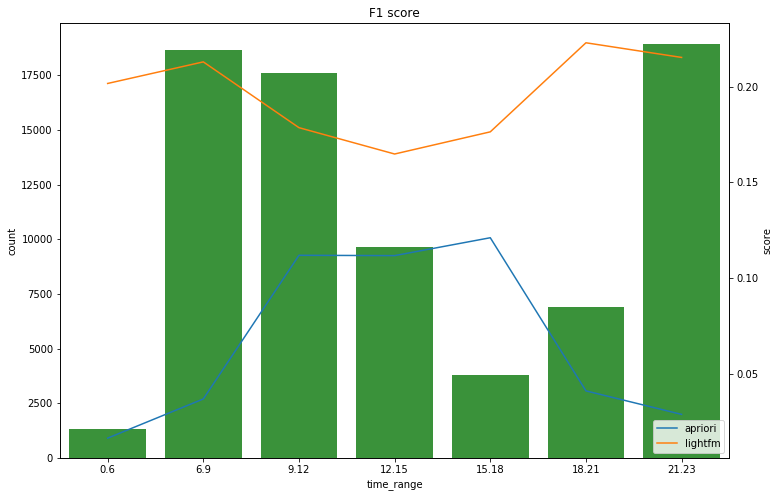

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

plt.figure(figsize=(12,8))
sns.countplot(x="time_range", data=orders_set, color=color[2])
axes2 = plt.twinx()
axes2.set_ylabel('score')
axes2.plot(choices, np.array(result_df.f1))
axes2.plot(choices, np.array(lightfm.f_test))
plt.legend(['apriori', 'lightfm'], loc='lower right')
plt.ylabel('score')
plt.xlabel('Range hour of day')
plt.title('F1 score')
plt.show()